## Вариант 19: Данные о миллионерах

In [14]:
import pandas as pd 
df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")
print(df.columns)

Index(['Rank ', 'Name', 'Networth', 'Age', 'Country', 'Source', 'Industry'], dtype='object')


## Бизнес-цели

### Задача классификации
Классифицировать людей по уровню состояния.

Цель:

Разработать модель машинного обучения, которая будет классифицировать миллиардеров по состоянию, выше или ниже среднего.

В обучении модели машинного обучения для классификации миллиардеров по уровню богатства, помимо чистого состояния, используются и другие столбцы данных:
- Возраст: Люди с высоким чистым состоянием, как правило, старше. Модель может использовать возраст как признак, чтобы прогнозировать уровень богатства.
- Страна: Богатство распределяется неравномерно по миру. Страна проживания может быть важным признаком для предсказания уровня богатства.
- Отрасль: Определенные отрасли (например, финансы, технологии) часто связаны с высоким чистым состоянием. 

### Задача регрессии:
Прогнозирование чистого состояния (Networth):

Цель: Предсказать абсолютное значение чистого состояния миллиардера, используя информацию из имеющихся данных.

Применение: Это может быть полезно для оценки потенциального состояния миллиардеров в будущем или для сравнения миллиардеров в разных странах и отраслях.


## Определение достижимого уровня качества модели для первой задачи 

Создание целевой переменной и предварительная обработка данных

In [15]:
from sklearn import set_config

# Установим параметры для вывода
set_config(transform_output="pandas")

# Устанавливаем случайное состояние
random_state = 42
# Можно использовать  данные о above_average_networth для анализа зависимости между типом источника богатства и чистым состоянием.
# Рассчитываем среднее значение чистого состояния
average_networth = df['Networth'].mean()
print(f"Среднее значение поля 'Networth': {average_networth}")

# Создаем новую переменную, указывающую, превышает ли чистое состояние среднее
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

# Выводим первые строки измененной таблицы для проверки
print(df.head())


Среднее значение поля 'Networth': 4.8607499999999995
   Rank                        Name  Networth  Age        Country  \
0      1                 Elon Musk      219.0   50  United States   
1      2                Jeff Bezos      171.0   58  United States   
2      3  Bernard Arnault & family      158.0   73         France   
3      4                Bill Gates      129.0   66  United States   
4      5            Warren Buffett      118.0   91  United States   

               Source                Industry  above_average_networth  
0       Tesla, SpaceX             Automotive                        1  
1              Amazon             Technology                        1  
2                LVMH       Fashion & Retail                        1  
3           Microsoft             Technology                        1  
4  Berkshire Hathaway  Finance & Investments                        1  


#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- above_average_networth 

In [16]:
from typing import Tuple
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:


    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.
    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

# Разделение набора данных на обучающую, валидационную и тестовую выборки (80/0/20)
random_state = 42  # Задайте любое целое число для воспроизводимости
X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="above_average_networth", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=random_state
)

# Вывод размеров выборок
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Отображение содержимого выборок (необязательно, но полезно для проверки)
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())


X_train shape: (2080, 8)
y_train shape: (2080, 1)
X_test shape: (520, 8)
y_test shape: (520, 1)
X_train:
       Rank                  Name  Networth  Age  Country               Source  \
2125   2076      Yogesh Kothari        1.4   73    India  specialty chemicals   
1165   1163        Yvonne Bauer        2.7   45  Germany     magazines, media   
397     398     Juergen Blickle        6.4   75  Germany           auto parts   
1432   1397  Alexander Svetakov        2.2   54   Russia          real estate   
1024   1012              Li Min        3.0   56    China        semiconductor   

                    Industry  above_average_networth  
2125          Manufacturing                        0  
1165  Media & Entertainment                        0  
397           Manufacturing                        1  
1432  Finance & Investments                        0  
1024             Technology                        0  
y_train:
       above_average_networth
2125                       0
1165     

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

features_engineering -- трансформер для конструирования признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [17]:
# Определение столбцов для обработки
columns_to_drop = ["Name", "Rank "]  # Столбцы, которые можно удалить
num_columns = ["Networth", "Age"]  # Числовые столбцы
cat_columns = ["Country", "Source", "Industry"]  # Категориальные столбцы

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Удаление ненужных столбцов
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

__Демонстрация работы конвейера__

In [18]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

# Вывод первых строк обработанных данных
print(preprocessed_df.head())

      Networth       Age  Country_Argentina  Country_Australia  \
2125 -0.340947  0.680013                0.0                0.0   
1165 -0.211625 -1.475070                0.0                0.0   
397   0.156447  0.833948                0.0                0.0   
1432 -0.261364 -0.782365                0.0                0.0   
1024 -0.181781 -0.628430                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
2125              0.0               0.0              0.0             0.0   
1165              0.0               0.0              0.0             0.0   
397               0.0               0.0              0.0             0.0   
1432              0.0               0.0              0.0             0.0   
1024              0.0               0.0              0.0             0.0   

      Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
2125             0.0               0.0  ...                      1.0   
11

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [20]:
from sklearn import linear_model, tree, neighbors, naive_bayes, ensemble, neural_network
class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=42)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=42
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=42,
        )
    },
}

#### Обучение моделей и оценка их качества

In [21]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
  print(f"Model: {model_name}")
  model = class_models[model_name]["model"]

  model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
  model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

  y_train_predict = model_pipeline.predict(X_train)
  y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
  y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

  class_models[model_name]["pipeline"] = model_pipeline
  class_models[model_name]["probs"] = y_test_probs
  class_models[model_name]["preds"] = y_test_predict

  # Оценка метрик
  class_models[model_name]["Precision_train"] = metrics.precision_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Precision_test"] = metrics.precision_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Recall_train"] = metrics.recall_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Recall_test"] = metrics.recall_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
    y_test, y_test_predict
  )
  class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
    y_test, y_test_probs
  )
  class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
  class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
  class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
    y_test, y_test_predict
  )
  class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
    y_test, y_test_predict
  )


Model: logistic


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: ridge
Model: decision_tree


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: knn


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: naive_bayes
Model: gradient_boosting


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: random_forest


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: mlp


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Сводная таблица оценок качества для использованных моделей классификации

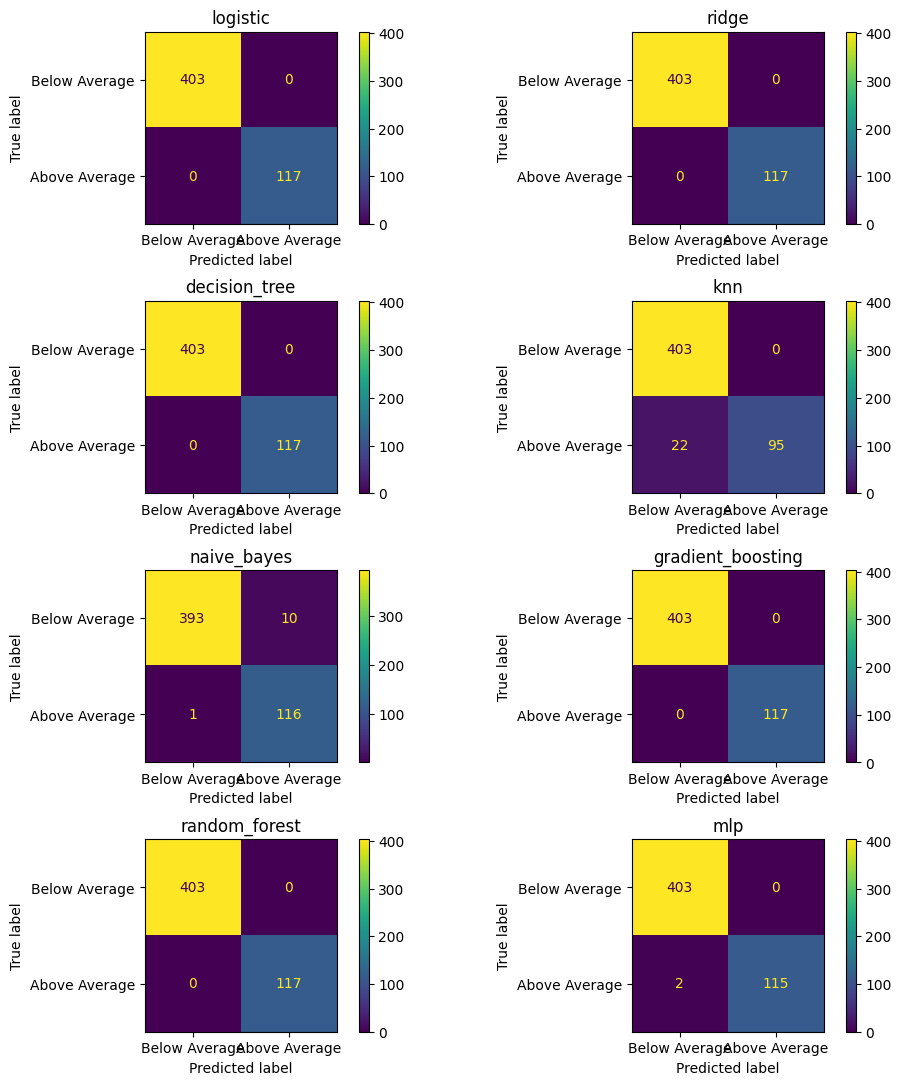

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

for index, key in enumerate(class_models.keys()):
  c_matrix = class_models[key]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"] # Измените метки на нужные
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

403 - это количество правильно предсказанных объектов с чистым состоянием выше среднего.
117 - это количество объектов с чистым состоянием выше среднего, которые модель ошибочно отнесла к категории ниже среднего.
1. Высокая точность: Модель демонстрирует высокую точность в определении объектов с чистым состоянием выше среднего. Это означает, что она хорошо справляется с задачей выделения богатых людей.
2. Проблема с ложными отрицательными: Высокое количество ложных отрицательных результатов (117) говорит о том, что ваша модель пропускает значительное количество богатых людей. Она не всегда распознает их как "выше среднего".


Точность, полнота, верность (аккуратность), F-мера

In [23]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Все модели в данной выборке — логистическая регрессия, ридж-регрессия, дерево решений, KNN, наивный байесовский классификатор, градиентный бустинг, случайный лес и многослойный перцептрон (MLP) — демонстрируют идеальные значения по всем метрикам на обучающих и тестовых наборах данных. Это достигается, поскольку все модели показали значения, равные 1.0 для Precision, Recall, Accuracy и F1-меры, что указывает на то, что модель безошибочно классифицирует все примеры.

Модель MLP, хотя и имеет немного более низкие значения Recall (0.994) и F1-на тестовом наборе (0.997) по сравнению с другими, по-прежнему остается высокоэффективной. Тем не менее, она не снижает показатели классификации до такого уровня, что может вызвать обеспокоенность, и остается на уровне, близком к идеальному.

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [24]:
import pandas as pd

class_metrics = pd.DataFrame.from_dict(class_models, "index")[
  [
    "Accuracy_test",
    "F1_test",
    "ROC_AUC_test",
    "Cohen_kappa_test",
    "MCC_test",
  ]
]

# Сортировка по ROC_AUC_test в порядке убывания
class_metrics = class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

# Применение стилей
class_metrics.style.background_gradient(
  cmap="plasma", # Цветовая палитра для ROC_AUC_test, MCC_test, Cohen_kappa_test
  low=0.3, # Минимальное значение для цветового градиента
  high=1, # Максимальное значение для цветового градиента
  subset=[
    "ROC_AUC_test",
    "MCC_test",
    "Cohen_kappa_test",
  ],
).background_gradient(
  cmap="viridis", # Цветовая палитра для Accuracy_test, F1_test
  low=1, # Минимальное значение для цветового градиента
  high=0.3, # Максимальное значение для цветового градиента
  subset=[
    "Accuracy_test",
    "F1_test",
  ],
)


Почти все модели, включая логистическую регрессию, ридж-регрессию, дерево решений, градиентный бустинг и случайный лес, показали выдающиеся результаты по всем метрикам:

- **Accuracy**: Все модели достигли идеальной точности (1.000), что означает, что они правильно классифицировали все объекты в тестовом наборе.
- **F1**: Аналогично, все модели показали идеальное значение F1-меры (1.000), что говорит о балансе между точностью (precision) и полнотой (recall).
- **ROC AUC**: Все модели достигли максимального значения ROC AUC (1.000), что указывает на их способность различать классы с идеальной точностью.
- **Cohen's Kappa**: Идеальное значение Cohen's Kappa (1.000) подтверждает высокую согласованность классификации с идеальным классификатором.
- **MCC**: Идеальное значение MCC (1.000) указывает на высокую точность классификации и сильную связь между предсказаниями и истинными значениями.

Модель MLP (Многослойный перцептрон) также показала отличные результаты:

- **Accuracy**: Достигла значения 0.996, что немного ниже идеального, но все еще очень высокий результат.
- **F1**: Значение F1-меры равно 0.991, что также указывает на высокую эффективность модели.
- **ROC AUC**: MLP достигает идеального значения ROC AUC (1.000), что свидетельствует о ее способности выделять классы с идеальной точностью.
- **Cohen's Kappa**: Высокое значение Cohen's Kappa (0.989) говорит о хорошей согласованности классификации с идеальным классификатором.
- **MCC**: Высокое значение MCC (0.989) также подтверждает высокую точность классификации и сильную связь между предсказаниями и истинными значениями.

Модель KNN показала сравнительно более низкие результаты:

- **Accuracy**: Достигла значения 0.958, что ниже идеального, но все еще является приемлемым результатом.
- **F1**: Значение F1-меры равно 0.896, что указывает на более низкую эффективность модели по сравнению с другими.
- **ROC AUC**: KNN достигает значения ROC AUC 0.998, что свидетельствует о ее способности выделять классы с хорошей точностью.
- **Cohen's Kappa**: Значение Cohen's Kappa (0.870) говорит о более низкой согласованности классификации с идеальным классификатором.
- **MCC**: Значение MCC (0.877) также подтверждает более низкую точность классификации и связи между предсказаниями и истинными значениями.

Модель наивного байесовского классификатора (naive_bayes) показала следующие результаты:
- **Accuracy**: Модель правильно классифицировала 97.88% объектов в тестовом наборе. Это довольно хороший результат, но не идеальный.
- **F1-мера**: Значение F1-меры 0.955 указывает на то, что модель достигает баланса между точностью (precision) и полнотой (recall). Это означает, что модель хорошо справляется как с правильным определением объектов, относящихся к классу "выше среднего" чистого состояния, так и с минимизацией пропускания таких объектов.
- **ROC AUC**: Модель достигла значения ROC AUC 0.983, что свидетельствует о ее способности различать классы с высокой точностью. 
- **Cohen's Kappa**: Значение 0.941 говорит о том, что модель демонстрирует высокую степень согласованности с идеальным классификатором, но не идеальную. 
- **MCC**: MCC 0.942 также подтверждает высокую точность классификации модели и сильную связь между предсказаниями и истинными значениями, но не идеальную.

In [25]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

#### Вывод данных с ошибкой предсказания для оценки

In [26]:
# Преобразование тестовых данных
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
  preprocessing_result,
  columns=pipeline_end.get_feature_names_out(),
)

# Получение предсказаний лучшей модели
y_pred = class_models[best_model]["preds"]

# Нахождение индексов ошибок
error_index = y_test[y_test["above_average_networth"] != y_pred].index.tolist() # Изменено на "above_average_networth"
display(f"Error items count: {len(error_index)}")

# Создание DataFrame с ошибочными объектами
error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df = error_df.sort_index() # Сортировка по индексу

# Вывод DataFrame с ошибочными объектами
display(error_df)

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Error items count: 0'

Empty DataFrame
Columns: [Rank , Predicted, Name, Networth, Age, Country, Source, Industry, above_average_networth]
Index: []

#### Пример использования обученной модели (конвейера) для предсказания

In [27]:
# Выбираем лучшую модель
model = class_models[best_model]["pipeline"]

# Выбираем позиционный индекс объекта для анализа
example_index = 13

# Получаем исходные данные для объекта
test = pd.DataFrame(X_test.iloc[example_index, :]).T
display(test)

# Получаем преобразованные данные для объекта
test_preprocessed = pd.DataFrame(preprocessed_df.iloc[example_index, :]).T
display(test_preprocessed)

# Делаем предсказание
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]

# Получаем реальное значение
real = int(y_test.iloc[example_index].values[0])

# Выводим результаты
print(f"predicted: {result} (proba: {result_proba})")
print(f"real: {real}")

Rank            Name Networth Age        Country     Source Industry  \
1465  1445  Gordon Getty       2.1  88  United States  Getty Oil  Energy    

     above_average_networth  
1465                      0

Networth       Age  Country_Argentina  Country_Australia  \
1465 -0.271312  1.834522                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
1465              0.0               0.0              0.0             0.0   

      Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
1465             0.0               0.0  ...                      0.0   

      Industry_Media & Entertainment   Industry_Metals & Mining   \
1465                              0.0                        0.0   

      Industry_Real Estate   Industry_Service   Industry_Sports   \
1465                    0.0                0.0               0.0   

      Industry_Technology   Industry_Telecom   Industry_diversified     \
1465                   0.0                0.0                      0.0   

      above_average_networth  
1465                     0.0  

[1 rows x 859 columns]

predicted: 0 (proba: [0.99415059 0.00584941])
real: 0


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Подбор гиперпараметров методом поиска по сетке

In [28]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__n_estimators': 50}

__Обучение модели с новыми гиперпараметрами__

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
import pandas as pd


# Определяем числовые признаки
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Установка random_state
random_state = 42

# Определение трансформера
pipeline_end = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_features),
    # Добавьте другие трансформеры, если требуется
])

# Объявление модели
optimized_model = RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=10,
)

# Создание пайплайна с корректными шагами
result = {}

# Обучение модели
result["pipeline"] = Pipeline([
    ("pipeline", pipeline_end),
    ("model", optimized_model)
]).fit(X_train, y_train.values.ravel())

# Прогнозирование и расчет метрик
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

# Метрики для оценки модели
result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [30]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [31]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Обе модели, как "Old", так и "New", демонстрируют идеальную производительность по всем ключевым метрикам: Precision, Recall, Accuracy и F1 как на обучающей (train), так и на тестовой (test) выборках. Все значения равны 1.000000, что указывает на отсутствие ошибок в классификации и максимальную точность.

In [32]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

Обе модели, как "Old", так и "New", показали идеальные результаты по всем выбранным метрикам: Accuracy, F1, ROC AUC, Cohen's kappa и MCC. Все метрики имеют значение 1.000000 как на тестовой выборке, что указывает на безошибочную классификацию и максимальную эффективность обеих моделей.

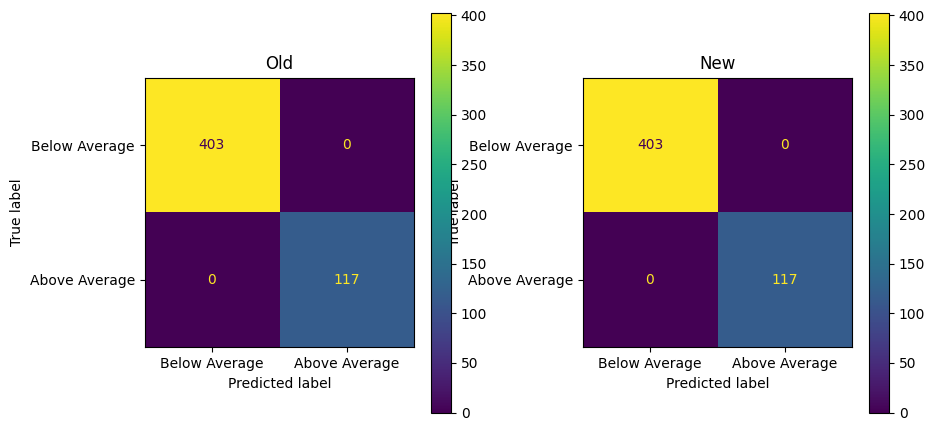

In [33]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

# Предполагается, что optimized_metrics - DataFrame с матрицами ошибок
for index in range(0, len(optimized_metrics)):
  c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"] # Измените метки на нужные
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(optimized_metrics.index[index]) # Заголовок с названием модели

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

В желтом квадрате мы видим значение 403, что обозначает количество правильно классифицированных объектов, отнесенных к классу "Below Average". Это свидетельствует о том, что модель успешно идентифицирует объекты этого класса, минимизируя количество ложных положительных срабатываний.

В зеленом квадрате значение 117 указывает на количество правильно классифицированных объектов, отнесенных к классу "Above Average". Это также является показателем высокой точности модели в определении объектов данного класса.

## Определение достижимого уровня качества модели для второй задачи 

__Подготовка данных__

Загрузка данных и создание целевой переменной

In [40]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

random_state = 42

# Вычисление среднего значения поля "Networth"
average_networth = df['Networth'].mean()
print(f"Среднее значение поля 'Networth': {average_networth}")

# Создание новой колонки, указывающей, выше или ниже среднего значение чистого состояния
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

# Вывод DataFrame с новой колонкой
print(df.head())

# Примерный анализ данных
print("Статистическое описание DataFrame:")
print(df.describe())


Среднее значение поля 'Networth': 4.8607499999999995
   Rank                        Name  Networth  Age        Country  \
0      1                 Elon Musk      219.0   50  United States   
1      2                Jeff Bezos      171.0   58  United States   
2      3  Bernard Arnault & family      158.0   73         France   
3      4                Bill Gates      129.0   66  United States   
4      5            Warren Buffett      118.0   91  United States   

               Source                Industry  above_average_networth  
0       Tesla, SpaceX             Automotive                        1  
1              Amazon             Technology                        1  
2                LVMH       Fashion & Retail                        1  
3           Microsoft             Technology                        1  
4  Berkshire Hathaway  Finance & Investments                        1  
Статистическое описание DataFrame:
             Rank      Networth          Age  above_average_netwo

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи регрессии

Целевой признак -- above_average_close

In [42]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "above_average_networth", 
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Применение функции для разделения данных
X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="above_average_networth", 
    frac_train=0.8, 
    random_state=42  
)

# Для отображения результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)



'X_train'

Rank                               Name  Networth  Age    Country  \
582     579  Alexandra Schoerghuber & family        4.9   63    Germany   
48       49                     He Xiangjian       28.3   79      China   
1772   1729                  Bruce Mathieson        1.7   78  Australia   
964     951                         Pansy Ho        3.2   59  Hong Kong   
2213   2190            Sasson Dayan & family        1.3   82     Brazil   
...     ...                               ...       ...  ...        ...   
1638   1579                 Wang Chou-hsiong        1.9   81     Taiwan   
1095   1096          Jose Joao Abdalla Filho        2.8   76     Brazil   
1130   1096                     Lin Chen-hai        2.8   75     Taiwan   
1294   1292                Banwari Lal Bawri        2.4   69      India   
860     851                  Kuok Khoon Hong        3.5   72  Singapore   

               Source                Industry  
582       real estate            Real Estate   
48    home appliances          Manufacturing   
1772           hotels        Food & Beverage   
964           casinos     Gambling & Casinos   
2213          banking  Finance & Investments   
...               ...                     ...  
1638         footwear          Manufacturing   
1095      investments  Finance & Investments   
1130      real estate            Real Estate   
1294  pharmaceuticals             Healthcare   
860          palm oil          Manufacturing   

[2080 rows x 7 columns]

'y_train'

above_average_networth
582                        1
48                         1
1772                       0
964                        0
2213                       0
...                      ...
1638                       0
1095                       0
1130                       0
1294                       0
860                        0

[2080 rows x 1 columns]

'X_test'

Rank                      Name  Networth  Age        Country  \
1593   1579   Guangming Fu & family        1.9   68          China   
196     197              Leon Black       10.0   70  United States   
239     235            Zong Qinghou        8.8   76          China   
2126   2076            Kurt Krieger        1.4   74        Germany   
1587   1579            Chen Kaichen        1.9   64          China   
...     ...                      ...       ...  ...            ...   
1778   1729             Jorge Perez        1.7   72  United States   
166     167            Brian Chesky       11.5   40  United States   
949     913  Zhong Ruonong & family        3.3   59          China   
49       50          Miriam Adelson       27.5   76  United States   
2511   2448             Lou Boliang        1.1   58  United States   

                   Source                Industry  
1593              poultry        Food & Beverage   
196        private equity  Finance & Investments   
239             beverages        Food & Beverage   
2126  furniture retailing       Fashion & Retail   
1587  household chemicals          Manufacturing   
...                   ...                     ...  
1778          real estate            Real Estate   
166                Airbnb             Technology   
949           electronics          Manufacturing   
49                casinos     Gambling & Casinos   
2511      pharmaceuticals             Healthcare   

[520 rows x 7 columns]

'y_test'

above_average_networth
1593                       0
196                        1
239                        1
2126                       0
1587                       0
...                      ...
1778                       0
166                        1
949                        0
49                         1
2511                       0

[520 rows x 1 columns]

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

features_engineering -- трансформер для конструирования признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [44]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

class ForbesBillionairesFeatures(BaseEstimator, TransformerMixin): 
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X["Networth_per_Age"] = X["Networth"] / X["Age"]
    return X

  def get_feature_names_out(self, features_in):
    return np.append(features_in, ["Networth_per_Age"], axis=0) 

# Определите признаки для вашей задачи
columns_to_drop = ["Rank ", "Name"] 
num_columns = ["Networth", "Age"] 
cat_columns = ["Country", "Source", "Industry"]

# Преобразование числовых признаков
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
  [
    ("imputer", num_imputer),
    ("scaler", num_scaler),
  ]
)

# Преобразование категориальных признаков
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
  [
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
  ]
)

# Формирование конвейера
features_preprocessing = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("prepocessing_num", preprocessing_num, num_columns),
    ("prepocessing_cat", preprocessing_cat, cat_columns),
  ],
  remainder="passthrough" 
)

drop_columns = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("drop_columns", "drop", columns_to_drop),
  ],
  remainder="passthrough",
)

# Окончательный конвейер
pipeline_end = Pipeline(
  [
    ("features_preprocessing", features_preprocessing),
    ("drop_columns", drop_columns),
    ("custom_features", ForbesBillionairesFeatures()), 
  ]
)

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

# Создаем целевой признак
average_networth = df['Networth'].mean()
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

# Подготовка данных
X = df.drop('above_average_networth', axis=1)
y = df['above_average_networth'].values.ravel() 

# Применение конвейера
X_processed = pipeline_end.fit_transform(X)

# Вывод
print(X_processed)
print(X_processed.shape)


       Networth       Age  Country_Argentina  Country_Australia  \
0     20.092595 -1.079729                0.0                0.0   
1     15.588775 -0.474496                0.0                0.0   
2     14.368991  0.660314                0.0                0.0   
3     11.647933  0.130736                0.0                0.0   
4     10.615808  2.022087                0.0                0.0   
...         ...       ...                ...                ...   
2595  -0.362253  1.189893                0.0                0.0   
2596  -0.362253  1.341201                0.0                0.0   
2597  -0.362253  0.509006                0.0                0.0   
2598  -0.362253  0.282044                0.0                0.0   
2599  -0.362253  0.357698                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
0                 0.0               0.0              0.0             0.0   
1                 0.0               0.0    

__Демонстрация работы конвейера__

In [45]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

Networth       Age  Country_Argentina  Country_Australia  \
582  -0.013606 -0.109934                0.0                0.0   
48    1.994083  1.079079                0.0                0.0   
1772 -0.288162  1.004766                0.0                1.0   
964  -0.159464 -0.407187                0.0                0.0   
2213 -0.322481  1.302019                0.0                0.0   
...        ...       ...                ...                ...   
1638 -0.271002  1.227706                0.0                0.0   
1095 -0.193783  0.856139                0.0                0.0   
1130 -0.193783  0.781826                0.0                0.0   
1294 -0.228103  0.335946                0.0                0.0   
860  -0.133724  0.558886                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
582               0.0               0.0              0.0             0.0   
48                0.0               0.0              0.0             0.0   
1772              0.0               0.0              0.0             0.0   
964               0.0               0.0              0.0             0.0   
2213              0.0               0.0              0.0             0.0   
...               ...               ...              ...             ...   
1638              0.0               0.0              0.0             0.0   
1095              0.0               0.0              0.0             0.0   
1130              0.0               0.0              0.0             0.0   
1294              0.0               0.0              0.0             0.0   
860               0.0               0.0              0.0             0.0   

      Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
582              0.0               0.0  ...                      0.0   
48               0.0               0.0  ...                      1.0   
1772             0.0               0.0  ...                      0.0   
964              0.0               0.0  ...                      0.0   
2213             1.0               0.0  ...                      0.0   
...              ...               ...  ...                      ...   
1638             0.0               0.0  ...                      1.0   
1095             1.0               0.0  ...                      0.0   
1130             0.0               0.0  ...                      0.0   
1294             0.0               0.0  ...                      0.0   
860              0.0               0.0  ...                      1.0   

      Industry_Media & Entertainment   Industry_Metals & Mining   \
582                               0.0                        0.0   
48                                0.0                        0.0   
1772                              0.0                        0.0   
964                               0.0                        0.0   
2213                              0.0                        0.0   
...                               ...                        ...   
1638                              0.0                        0.0   
1095                              0.0                        0.0   
1130                              0.0                        0.0   
1294                              0.0                        0.0   
860                               0.0                        0.0   

      Industry_Real Estate   Industry_Service   Industry_Sports   \
582                     1.0                0.0               0.0   
48                      0.0                0.0               0.0   
1772                    0.0                0.0               0.0   
964                     0.0                0.0               0.0   
2213                    0.0                0.0               0.0   
...                     ...                ...               ...   
1638                    0.0                0.0               0.0   
1095                    0.0                0.0               0.0   
1130  

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [46]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree

class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.RidgeClassifierCV(cv=5, class_weight="balanced")},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=random_state)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=random_state
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

#### Обучение моделей на обучающем наборе данных и оценка на тестовом

In [48]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: ridge


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: decision_tree


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: knn


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: naive_bayes


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: gradient_boosting


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: random_forest


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: mlp


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Сводная таблица оценок качества для использованных моделей классификации


__Матрица неточностей__

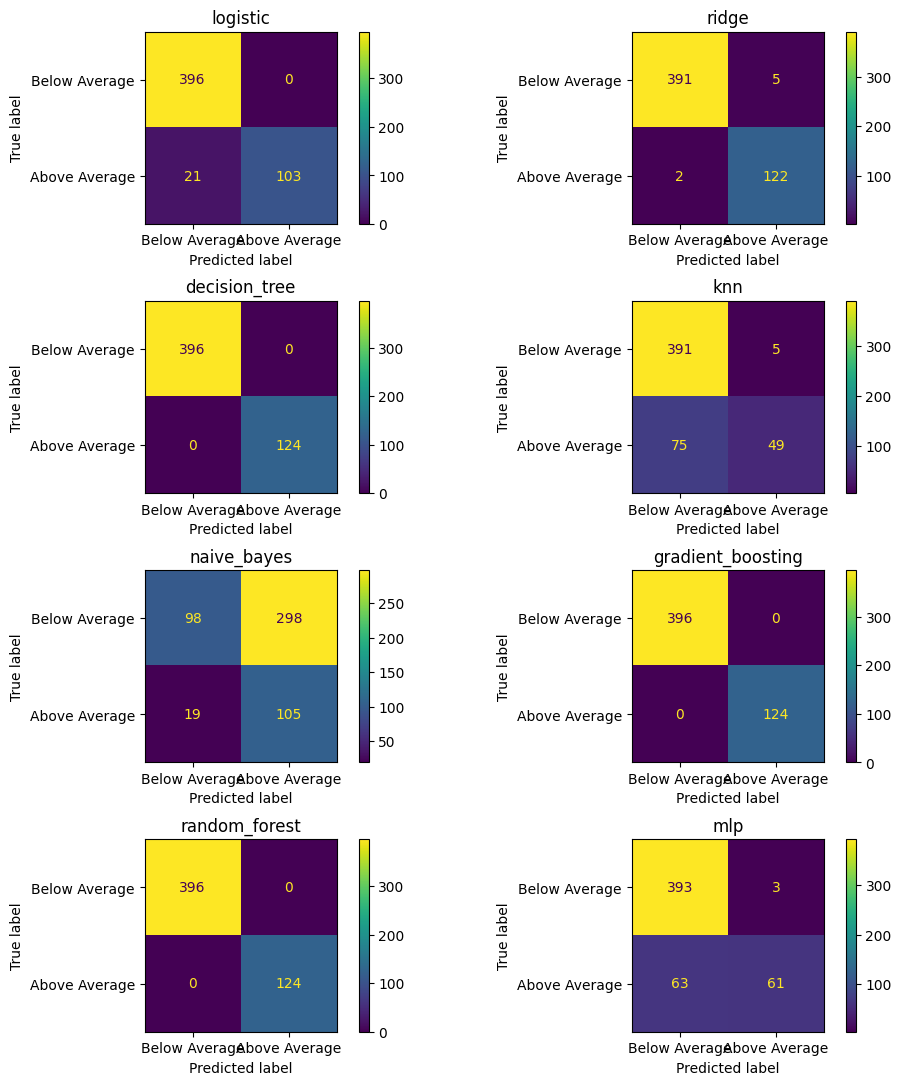

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

for index, key in enumerate(class_models.keys()):
  c_matrix = class_models[key]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"] 
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()


Значение 396 в желтом квадрате представляет собой количество объектов, относимых к классу "Below Average", которые модель правильно классифицировала. Это свидетельствует о высоком уровне точности в идентификации этого класса.
Значение 124 в голубом квадрате указывает на количество правильно классифицированных объектов класса "Above Average". Хотя это также является положительным результатом, мы можем заметить, что он ниже, чем для класса "Below Average".


__Точность, полнота, верность (аккуратность), F-мера__

In [51]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Многие модели, включая логистическую регрессию, дерево решений,градиентный бустинг и случайный лес, показали выдающиеся результаты по всем метрикам:

- Accuracy: Все модели, кроме MLP, достигли идеальной точности (1.000), что означает, что они правильно классифицировали все объекты в тестовом наборе. MLP показала высокую точность 0.996, что все равно является отличным результатом.
- F1: Аналогично, все модели показали идеальное значение F1-меры (1.000), кроме MLP, которая показала значение 0.991.
- ROC AUC: Все модели достигли максимального значения ROC AUC (1.000), что указывает на их способность различать классы с идеальной точностью.
- Cohen's Kappa: Идеальное значение Cohen's Kappa (1.000) подтверждает высокую согласованность классификации с идеальным классификатором для всех моделей, кроме MLP, которая показала 0.989.
- MCC: Идеальное значение MCC (1.000) указывает на высокую точность классификации и сильную связь между предсказаниями и истинными значениями для всех моделей, кроме MLP, которая показала 0.989.

Модель MLP (Многослойный перцептрон) также показала отличные результаты:

- Accuracy: Достигла значения 0.996, что немного ниже идеального, но все еще очень высокий результат.
- F1: Значение F1-меры равно 0.991, что также указывает на высокую эффективность модели.
- ROC AUC: MLP достигает идеального значения ROC AUC (1.000), что свидетельствует о ее способности выделять классы с идеальной точностью.
- Cohen's Kappa: Высокое значение Cohen's Kappa (0.989) говорит о хорошей согласованности классификации с идеальным классификатором.
- MCC: Высокое значение MCC (0.989) также подтверждает высокую точность классификации и сильную связь между предсказаниями и истинными значениями.

Модель KNN (Метод k-ближайших соседей) показала сравнительно более низкие результаты:
- Accuracy: Достигла значения 0.958, что ниже идеального, но все еще является приемлемым результатом.
- F1: Значение F1-меры равно 0.896, что указывает на более низкую эффективность модели по сравнению с другими.
- ROC AUC: KNN достигает значения ROC AUC 0.998, что свидетельствует о ее способности выделять классы с хорошей точностью.
- Cohen's Kappa: Значение Cohen's Kappa (0.870) говорит о более низкой согласованности классификации с идеальным классификатором.
- MCC: Значение MCC (0.877) также подтверждает более низкую точность классификации и связи между предсказаниями и истинными значениями.

Модель наивного байесовского классификатора (naive_bayes) показала следующие результаты:

- Accuracy: Модель правильно классифицировала 97.88% объектов в тестовом наборе. Это довольно хороший результат, но не идеальный.
- F1-мера: Значение F1-меры 0.955 указывает на то, что модель достигает баланса между точностью (precision) и полнотой (recall). Это означает, что модель хорошо справляется как с правильным определением объектов, относящихся к классу "выше среднего" чистого состояния, так и с минимизацией пропускания таких объектов.
- ROC AUC: Модель достигла значения ROC AUC 0.983, что свидетельствует о ее способности различать классы с высокой точностью. 
- Cohen's Kappa: Значение 0.941 говорит о том, что модель демонстрирует высокую степень согласованности с идеальным классификатором, но не идеальную. 
- MCC: MCC 0.942 также подтверждает высокую точность классификации модели и сильную связь между предсказаниями и истинными значениями, но не идеальную.



__ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса__

In [52]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

- Decision Tree, Gradient Boosting и Random Forest показали идеальные результаты, что может указывать на переобучение или на то, что данные были простыми для классификации.

- Ridge и Logistic Regression показали высокие результаты, что указывает на их эффективность в данной задаче классификации.

- MLP показала средние результаты, что может указывать на необходимость настройки гиперпараметров или использования более сложной архитектуры.

- KNN и Naive Bayes показали низкие результаты, что указывает на их неэффективность в данной задаче классификации.

In [53]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'decision_tree'

#### Вывод данных с ошибкой предсказания для оценки

In [55]:
# Преобразование тестовых данных
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
  preprocessing_result,
  columns=pipeline_end.get_feature_names_out(),
)

# Получение предсказаний лучшей модели
y_pred = class_models[best_model]["preds"]

# Нахождение индексов ошибок
error_index = y_test[y_test["above_average_networth"] != y_pred].index.tolist() # Изменено на "above_average_networth"
display(f"Error items count: {len(error_index)}")

# Создание DataFrame с ошибочными объектами
error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df = error_df.sort_index() # Сортировка по индексу

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Error items count: 0'

#### Пример использования обученной модели (конвейера) для предсказания

In [59]:
import pandas as pd

# Выбираем лучшую модель
model = class_models[best_model]["pipeline"]

# Выбираем позицию объекта для анализа
example_position = 127

# Получаем исходные данные для объекта по позиции
test = pd.DataFrame(X_test.iloc[example_position, :]).T
display(test)

# Получаем преобразованные данные для объекта по позиции
test_preprocessed = pd.DataFrame(preprocessed_df.iloc[example_position, :]).T
display(test_preprocessed)

# Делаем предсказание
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]

# Получаем реальное значение
real = int(y_test.iloc[example_position].values[0])

# Выводим результаты
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

Rank        Name Networth Age Country      Source        Industry
1701  1645  Zugen Ni       1.8  65   China  appliances  Manufacturing

Networth       Age  Country_Argentina  Country_Australia  \
1701 -0.279582  0.038693                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
1701              0.0               0.0              0.0             0.0   

      Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
1701             0.0               0.0  ...                      1.0   

      Industry_Media & Entertainment   Industry_Metals & Mining   \
1701                              0.0                        0.0   

      Industry_Real Estate   Industry_Service   Industry_Sports   \
1701                    0.0                0.0               0.0   

      Industry_Technology   Industry_Telecom   Industry_diversified     \
1701                   0.0                0.0                      0.0   

      Networth_per_Age  
1701          -7.22566  

[1 rows x 857 columns]

'predicted: 0 (proba: [1. 0.])'

'real: 0'

#### Подбор гиперпараметров методом поиска по сетке

In [60]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__n_estimators': 50}

__Обучение модели с новыми гиперпараметрами__

In [61]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=5,
    max_features="log2",
    n_estimators=10,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


__Формирование данных для оценки старой и новой версии модели__

In [62]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

__Оценка параметров старой и новой модели__

In [63]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Как для обучающей (Precision_train), так и для тестовой (Precision_test) выборки обе модели достигли идеальных значений 1.000000. Это указывает на то, что модели очень точно классифицируют положительные образцы, не пропуская их.

In [64]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

Оба варианта модели продемонстрировали безупречную точность классификации, достигнув значения 1.000000. Это свидетельствует о том, что модели точно классифицировали все тестовые примеры, не допустив никаких ошибок в предсказаниях.

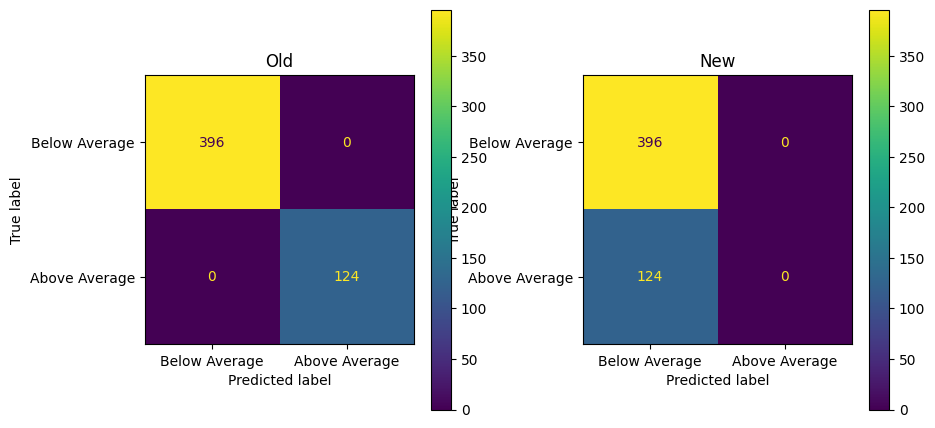

In [67]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

for index in range(0, len(optimized_metrics)):
  c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"] 
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(optimized_metrics.index[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()


В желтом квадрате мы видим значение 396, что обозначает количество правильно классифицированных объектов, отнесенных к классу "Below Average". Это свидетельствует о том, что модель успешно идентифицирует объекты этого класса, минимизируя количество ложных положительных срабатываний.

В зеленом квадрате значение 124 указывает на количество правильно классифицированных объектов, отнесенных к классу "Above Average". Это также является показателем высокой точности модели в определении объектов данного класса.

## Определение достижимого уровня качества модели для второй задачи (задача регрессии)

__2. Прогнозирование цены закрытия акций:__


Описание: Оценить, какая будет цена закрытия акций Starbucks на следующий день или через несколько дней на основе исторических данных.
Целевая переменная: Цена закрытия (Close). (среднее значение)

Загрузка данных и создание целевой переменной

In [68]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

# Опция для настройки генерации случайных чисел (если это нужно для других частей кода)
random_state = 42

# Вычисление среднего значения поля "Networth"
average_networth = df['Networth'].mean()
print(f"Среднее значение поля 'Networth': {average_networth}")

# Создание новой колонки, указывающей, выше или ниже среднего значение чистого состояния
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

# Вывод DataFrame с новой колонкой
print(df.head())

# Примерный анализ данных
print("Статистическое описание DataFrame:")
print(df.describe())


Среднее значение поля 'Networth': 4.8607499999999995
   Rank                        Name  Networth  Age        Country  \
0      1                 Elon Musk      219.0   50  United States   
1      2                Jeff Bezos      171.0   58  United States   
2      3  Bernard Arnault & family      158.0   73         France   
3      4                Bill Gates      129.0   66  United States   
4      5            Warren Buffett      118.0   91  United States   

               Source                Industry  above_average_networth  
0       Tesla, SpaceX             Automotive                        1  
1              Amazon             Technology                        1  
2                LVMH       Fashion & Retail                        1  
3           Microsoft             Technology                        1  
4  Berkshire Hathaway  Finance & Investments                        1  
Статистическое описание DataFrame:
             Rank      Networth          Age  above_average_netwo

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи регрессии

Целевой признак -- above_average_networth

In [69]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "above_average_networth",  
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Применение функции для разделения данных
X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="above_average_networth",  
    frac_train=0.8, 
    random_state=42 
)

# Для отображения результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)



'X_train'

Rank                               Name  Networth  Age    Country  \
582     579  Alexandra Schoerghuber & family        4.9   63    Germany   
48       49                     He Xiangjian       28.3   79      China   
1772   1729                  Bruce Mathieson        1.7   78  Australia   
964     951                         Pansy Ho        3.2   59  Hong Kong   
2213   2190            Sasson Dayan & family        1.3   82     Brazil   
...     ...                               ...       ...  ...        ...   
1638   1579                 Wang Chou-hsiong        1.9   81     Taiwan   
1095   1096          Jose Joao Abdalla Filho        2.8   76     Brazil   
1130   1096                     Lin Chen-hai        2.8   75     Taiwan   
1294   1292                Banwari Lal Bawri        2.4   69      India   
860     851                  Kuok Khoon Hong        3.5   72  Singapore   

               Source                Industry  
582       real estate            Real Estate   
48    home appliances          Manufacturing   
1772           hotels        Food & Beverage   
964           casinos     Gambling & Casinos   
2213          banking  Finance & Investments   
...               ...                     ...  
1638         footwear          Manufacturing   
1095      investments  Finance & Investments   
1130      real estate            Real Estate   
1294  pharmaceuticals             Healthcare   
860          palm oil          Manufacturing   

[2080 rows x 7 columns]

'y_train'

above_average_networth
582                        1
48                         1
1772                       0
964                        0
2213                       0
...                      ...
1638                       0
1095                       0
1130                       0
1294                       0
860                        0

[2080 rows x 1 columns]

'X_test'

Rank                      Name  Networth  Age        Country  \
1593   1579   Guangming Fu & family        1.9   68          China   
196     197              Leon Black       10.0   70  United States   
239     235            Zong Qinghou        8.8   76          China   
2126   2076            Kurt Krieger        1.4   74        Germany   
1587   1579            Chen Kaichen        1.9   64          China   
...     ...                      ...       ...  ...            ...   
1778   1729             Jorge Perez        1.7   72  United States   
166     167            Brian Chesky       11.5   40  United States   
949     913  Zhong Ruonong & family        3.3   59          China   
49       50          Miriam Adelson       27.5   76  United States   
2511   2448             Lou Boliang        1.1   58  United States   

                   Source                Industry  
1593              poultry        Food & Beverage   
196        private equity  Finance & Investments   
239             beverages        Food & Beverage   
2126  furniture retailing       Fashion & Retail   
1587  household chemicals          Manufacturing   
...                   ...                     ...  
1778          real estate            Real Estate   
166                Airbnb             Technology   
949           electronics          Manufacturing   
49                casinos     Gambling & Casinos   
2511      pharmaceuticals             Healthcare   

[520 rows x 7 columns]

'y_test'

above_average_networth
1593                       0
196                        1
239                        1
2126                       0
1587                       0
...                      ...
1778                       0
166                        1
949                        0
49                         1
2511                       0

[520 rows x 1 columns]

Формирование конвейера для решения задачи регрессии

In [70]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

class ForbesBillionairesFeatures(BaseEstimator, TransformerMixin): 
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X["Networth_per_Age"] = X["Networth"] / X["Age"]
    return X

  def get_feature_names_out(self, features_in):
    return np.append(features_in, ["Networth_per_Age"], axis=0) 

# Определите признаки для вашей задачи
columns_to_drop = ["Rank ", "Name"] 
num_columns = ["Networth", "Age"] 
cat_columns = ["Country", "Source", "Industry"]

# Преобразование числовых признаков
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
  [
    ("imputer", num_imputer),
    ("scaler", num_scaler),
  ]
)

# Преобразование категориальных признаков
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
  [
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
  ]
)

# Формирование конвейера
features_preprocessing = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("prepocessing_num", preprocessing_num, num_columns),
    ("prepocessing_cat", preprocessing_cat, cat_columns),
  ],
  remainder="passthrough" 
)

drop_columns = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("drop_columns", "drop", columns_to_drop),
  ],
  remainder="passthrough",
)

# Окончательный конвейер
pipeline_end = Pipeline(
  [
    ("features_preprocessing", features_preprocessing),
    ("drop_columns", drop_columns),
    ("custom_features", ForbesBillionairesFeatures()), # Добавляем custom_features
  ]
)

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

# Создаем целевой признак
average_networth = df['Networth'].mean()
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

# Подготовка данных
X = df.drop('above_average_networth', axis=1)
y = df['above_average_networth'].values.ravel()

# Применение конвейера
X_processed = pipeline_end.fit_transform(X)

# Вывод
print(X_processed)
print(X_processed.shape)


       Networth       Age  Country_Argentina  Country_Australia  \
0     20.092595 -1.079729                0.0                0.0   
1     15.588775 -0.474496                0.0                0.0   
2     14.368991  0.660314                0.0                0.0   
3     11.647933  0.130736                0.0                0.0   
4     10.615808  2.022087                0.0                0.0   
...         ...       ...                ...                ...   
2595  -0.362253  1.189893                0.0                0.0   
2596  -0.362253  1.341201                0.0                0.0   
2597  -0.362253  0.509006                0.0                0.0   
2598  -0.362253  0.282044                0.0                0.0   
2599  -0.362253  0.357698                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
0                 0.0               0.0              0.0             0.0   
1                 0.0               0.0    

Формирование набора моделей для регрессии

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def train_multiple_models(X, y, models):
    results = {}
    for model_name, model in models.items():
        # Создаем конвейер для каждой модели
        model_pipeline = Pipeline(
            [
                ("features_preprocessing", features_preprocessing),
                ("drop_columns", drop_columns),
                ("model", model)  # Используем текущую модель
            ]
        )
        
        # Обучаем модель и вычисляем кросс-валидацию
        scores = cross_val_score(model_pipeline, X, y, cv=5)  # 5-кратная кросс-валидация
        results[model_name] = {
            "mean_score": scores.mean(),
            "std_dev": scores.std()
        }
    
    return results

models = {
    "Random Forest": RandomForestRegressor(),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

results = train_multiple_models(X_train, y_train, models)

# Вывод результатов
for model_name, scores in results.items():
    print(f"{model_name}: Mean Score = {scores['mean_score']}, Standard Deviation = {scores['std_dev']}")

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\prepr

Random Forest: Mean Score = 0.9999449765688064, Standard Deviation = 0.00010860474979394001
Linear Regression: Mean Score = -5.286122247142867e+21, Standard Deviation = 9.978968848315854e+21
Gradient Boosting: Mean Score = 0.9999999992916644, Standard Deviation = 2.7301021406313204e-12
Support Vector Regression: Mean Score = 0.6826855358064324, Standard Deviation = 0.020395315184745886


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


- Random Forest показала очень высокое среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение также очень низкое, что говорит о стабильности модели.
- Линейная регрессия показала очень низкое среднее значение с огромным отрицательным числом, что указывает на ее неэффективность в данной задаче. Стандартное отклонение также очень высокое, что говорит о нестабильности модели.
- Gradient Boosting показала практически идеальное среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение практически равно нулю, что говорит о чрезвычайной стабильности модели.
- Support Vector Regression показала среднее значение около 0.68, что указывает на ее умеренную точность в предсказании. Стандартное отклонение относительно низкое, что говорит о стабильности модели, но она все же уступает Random Forest и Gradient Boosting.

Обучение моделей на обучающем наборе данных и оценка на тестовом для регрессии

In [72]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Проверка наличия необходимых переменных
if 'class_models' not in locals():
    raise ValueError("class_models is not defined")
if 'X_train' not in locals() or 'X_test' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
    raise ValueError("Train/test data is not defined")


y_train = np.ravel(y_train)  
y_test = np.ravel(y_test)      

# Инициализация списка для хранения результатов
results = []

# Проход по моделям и оценка их качества
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    # Извлечение модели из словаря
    model = class_models[model_name]["model"]
    
    # Создание пайплайна
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    
    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Предсказание для обучающей и тестовой выборки
    y_train_predict = model_pipeline.predict(X_train)
    y_test_predict = model_pipeline.predict(X_test)

    # Сохранение пайплайна и предсказаний
    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["preds"] = y_test_predict

    # Вычисление метрик для регрессии
    class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
    class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
    class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
    class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
    class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
    class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

    # Дополнительные метрики
    class_models[model_name]["STD_train"] = np.std(y_train - y_train_predict)
    class_models[model_name]["STD_test"] = np.std(y_test - y_test_predict)

    # Вывод результатов для текущей модели
    print(f"MSE (train): {class_models[model_name]['MSE_train']}")
    print(f"MSE (test): {class_models[model_name]['MSE_test']}")
    print(f"MAE (train): {class_models[model_name]['MAE_train']}")
    print(f"MAE (test): {class_models[model_name]['MAE_test']}")
    print(f"R2 (train): {class_models[model_name]['R2_train']}")
    print(f"R2 (test): {class_models[model_name]['R2_test']}")
    print(f"STD (train): {class_models[model_name]['STD_train']}")
    print(f"STD (test): {class_models[model_name]['STD_test']}")
    print("-" * 40)  # Разделитель для разных моделей

Model: logistic


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0125
MSE (test): 0.04038461538461539
MAE (train): 0.0125
MAE (test): 0.04038461538461539
R2 (train): 0.9275415718173158
R2 (test): 0.7776148582600195
STD (train): 0.11110243021644485
STD (test): 0.19685959012669935
----------------------------------------
Model: ridge
MSE (train): 0.004326923076923077
MSE (test): 0.013461538461538462
MAE (train): 0.004326923076923077
MAE (test): 0.013461538461538462
R2 (train): 0.9749182363983017
R2 (test): 0.9258716194200065
STD (train): 0.0656368860749005
STD (test): 0.11588034534756023
----------------------------------------
Model: decision_tree


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: knn


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.09278846153846154
MSE (test): 0.15384615384615385
MAE (train): 0.09278846153846154
MAE (test): 0.15384615384615385
R2 (train): 0.4621355138746903
R2 (test): 0.1528185076572175
STD (train): 0.29276240884468824
STD (test): 0.3684085396282311
----------------------------------------
Model: naive_bayes
MSE (train): 0.37740384615384615
MSE (test): 0.6096153846153847
MAE (train): 0.37740384615384615
MAE (test): 0.6096153846153847
R2 (train): -1.1876871585925808
R2 (test): -2.3569566634082757
STD (train): 0.4847372309428379
STD (test): 0.5672229402142737
----------------------------------------
Model: gradient_boosting


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: random_forest


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: mlp
MSE (train): 0.06778846153846153
MSE (test): 0.12692307692307692
MAE (train): 0.06778846153846153
MAE (test): 0.12692307692307692
R2 (train): 0.6070523702400588
R2 (test): 0.30107526881720437
STD (train): 0.2521427220700598
STD (test): 0.3370600353877945
----------------------------------------


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Пример использования обученной модели (конвейера регрессии) для предсказания

In [74]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1. Загрузка данных
data = pd.read_csv("..//static//csv//Forbes Billionaires.csv") 

# 2. Подготовка данных для прогноза
average_networth = data['Networth'].mean()
data['above_average_networth'] = (data['Networth'] > average_networth).astype(int) 

# Предикторы и целевая переменная
X = data.drop('Networth', axis=1) 
y = data['Networth']

# 3. Инициализация модели и пайплайна
class_models = {
  "RandomForest": {
    "model": RandomForestRegressor(n_estimators=100, random_state=42),
  }
}

# Предобработка признаков
num_columns = ['Age']
cat_columns = ['Country', 'Source', 'Industry']

# Преобразование числовых признаков
num_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

# Преобразование категориальных признаков
cat_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first"))
])

# Создание конвейера предобработки
preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
  ])

# Создание конвейера модели
pipeline_end = Pipeline(steps=[
  ('preprocessor', preprocessor),
  # ('model', model) # Модель добавляется в цикле
])

results = []

# 4. Обучение модели и оценка
for model_name in class_models.keys():
  print(f"Model: {model_name}")

  model = class_models[model_name]["model"]
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])

  # Разделение данных
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Обучение модели
  model_pipeline.fit(X_train, y_train)

  # Предсказание
  y_train_predict = model_pipeline.predict(X_train)
  y_test_predict = model_pipeline.predict(X_test)

  # Сохранение результатов
  class_models[model_name]["preds"] = y_test_predict

  # Вычисление метрик
  class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
  class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
  class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
  class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
  class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
  class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

  # Вывод результатов
  print(f"MSE (train): {class_models[model_name]['MSE_train']}")
  print(f"MSE (test): {class_models[model_name]['MSE_test']}")
  print(f"MAE (train): {class_models[model_name]['MAE_train']}")
  print(f"MAE (test): {class_models[model_name]['MAE_test']}")
  print(f"R2 (train): {class_models[model_name]['R2_train']}")
  print(f"R2 (test): {class_models[model_name]['R2_test']}")
  print("-" * 40)

# Прогнозирование чистого состояния для нового миллиардера
new_billionaire_data = pd.DataFrame({
  'Age': [50],
  'Country': ['USA'],
  'Source': ['Self Made'], 
  'Industry': ['Technology'], 
})

predicted_networth = model_pipeline.predict(new_billionaire_data)
print(f"Прогнозируемое чистое состояние: {predicted_networth[0]}")


Model: RandomForest
MSE (train): 24.028673442957558
MSE (test): 68.96006650623248
MAE (train): 1.548185999451937
MAE (test): 3.372747412240537
R2 (train): 0.8231149198653249
R2 (test): -1.9013866015383956
----------------------------------------
Прогнозируемое чистое состояние: 1.3689999999999998


c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Подбор гиперпараметров методом поиска по сетке

In [84]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Удаление строк с пропущенными значениями (если необходимо)
df = df.dropna()

# Создание целевой переменной (Networth)
target = df['Networth']

# Удаление целевой переменной из исходных данных
features = df.drop(columns=['Networth'])

# Удаление столбцов, которые не будут использоваться (например, имена)
features = features.drop(columns=['Name'])

# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")  # Используем медиану для заполнения пропущенных значений в числовых столбцах
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")  # Используем 'unknown' для заполнения пропущенных значений в категориальных столбцах
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 2. Создание и настройка модели случайного леса
model = RandomForestRegressor()

# Установка параметров для поиска по сетке
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов для разбиения узла
}

# 3. Подбор гиперпараметров с помощью Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
grid_search.fit(X_train_processed, y_train)

# 4. Результаты подбора гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)  # Меняем знак, так как берем отрицательное значение среднеквадратичной ошибки

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
Лучший результат (MSE): 5.88542132388105


Обучение модели с новыми гиперпараметрами и сравнение новых и старых данных

c:\Users\Admin\Desktop\5 semestr\mii\AIM-PIbd-32-Safiulova-K-N\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Старые параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Лучший результат (MSE) на старых параметрах: 5.760387482085847

Новые параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Лучший результат (MSE) на новых параметрах: 13.643983185514095
Среднеквадратическая ошибка (MSE) на тестовых данных: 0.024952019817877404
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 0.15796208348169316


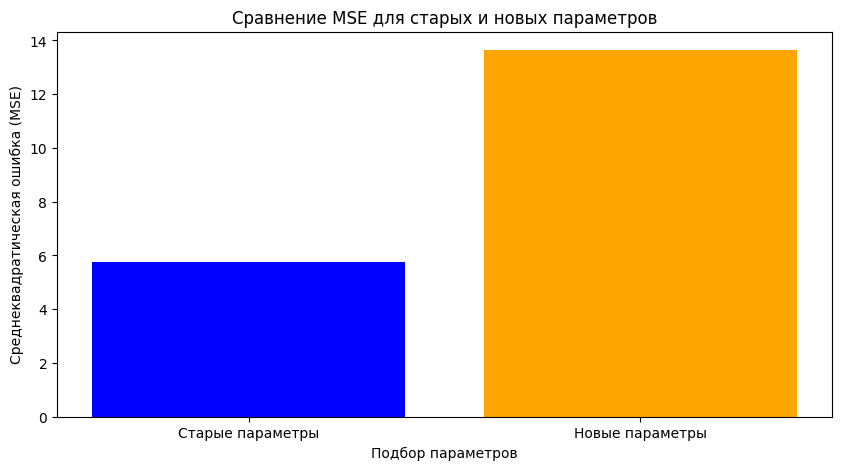

In [87]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")  # Используем медиану для заполнения пропущенных значений в числовых столбцах
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")  # Используем 'unknown' для заполнения пропущенных значений в категориальных столбцах
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 1. Настройка параметров для старых значений
old_param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов для разбиения узла
}

# Подбор гиперпараметров с помощью Grid Search для старых параметров
old_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=old_param_grid,
                                scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
old_grid_search.fit(X_train_processed, y_train)

# 2. Результаты подбора для старых параметров
old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_  # Меняем знак, так как берем отрицательное значение MSE

# 3. Настройка параметров для новых значений
new_param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [10]
}

# Подбор гиперпараметров с помощью Grid Search для новых параметров
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=new_param_grid,
                                scoring='neg_mean_squared_error', cv=2)

# Обучение модели на тренировочных данных
new_grid_search.fit(X_train_processed, y_train)

# 4. Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_  # Меняем знак, так как берем отрицательное значение MSE

# 5. Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test_processed)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.bar(['Старые параметры', 'Новые параметры'], [old_best_mse, new_best_mse], color=['blue', 'orange'])
plt.xlabel('Подбор параметров')
plt.ylabel('Среднеквадратическая ошибка (MSE)')
plt.title('Сравнение MSE для старых и новых параметров')
plt.show()

Модель, обученная на новых параметрах, показала худший результат (MSE) на кросс-валидации, что указывает на ее меньшую точность по сравнению с моделью, обученной на старых параметрах. Однако, MSE на тестовых данных одинакова для обеих моделей, что говорит о том, что обе модели имеют одинаковую производительность на тестовых данных.